# 任务一 CNN手绘图像分类

## 1.1 读入图像并展示
1. 每类展示10个样本图像
2. 将‘ambulance’,‘apple’,‘bear’,‘bicycle’,‘bird’,‘bus’,‘cat’ 7个类的数据，每类按照7:2:1划分为“训练集”、“验证集”和“分布内测试集（IN-test）”
3. 将‘foot’,‘owl’,‘pig‘作为“分布外数据集”，每类抽取100张图像构成“分布外测试数据集（OOD-test）

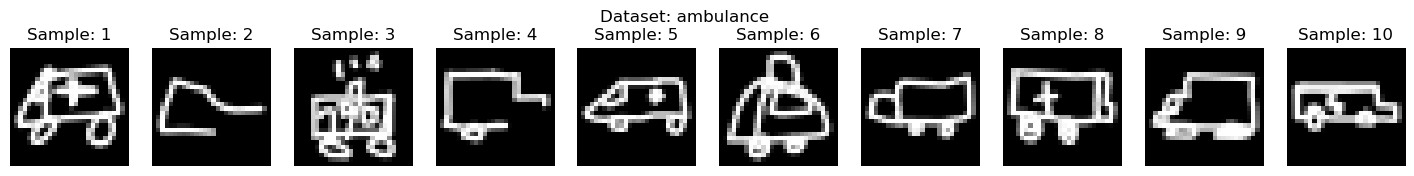

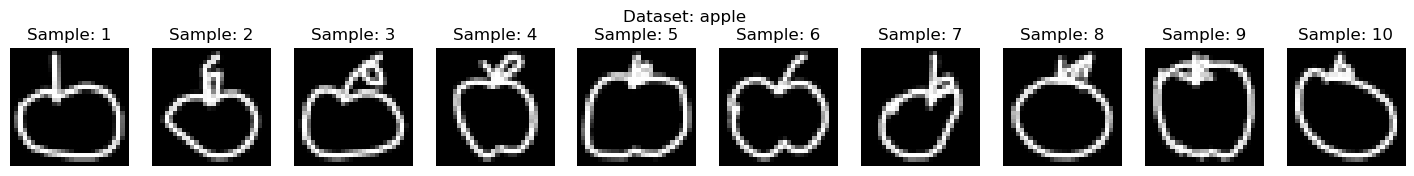

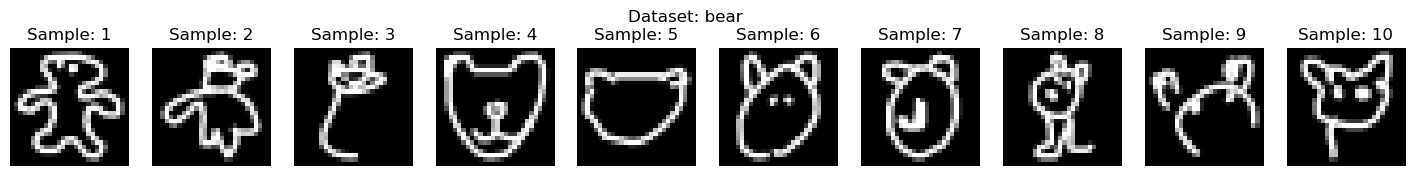

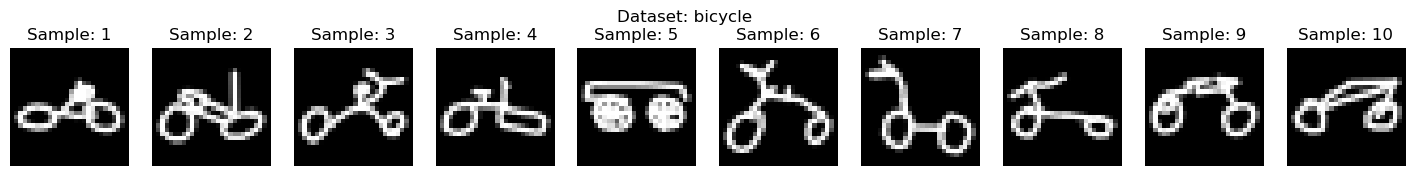

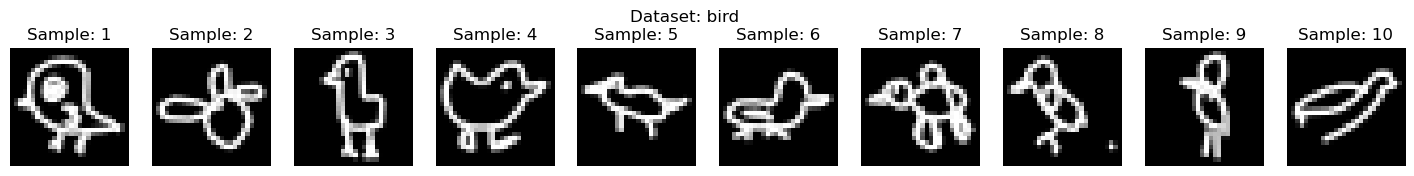

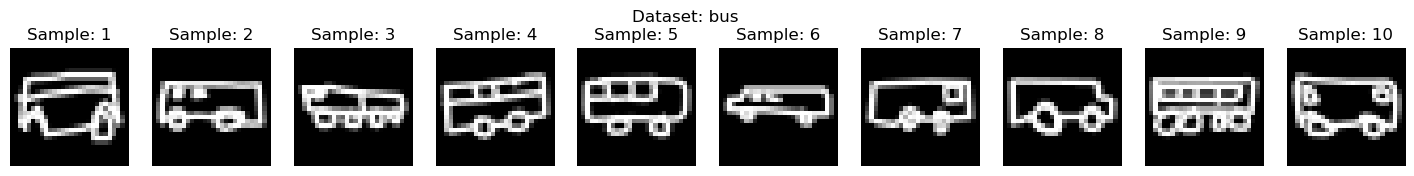

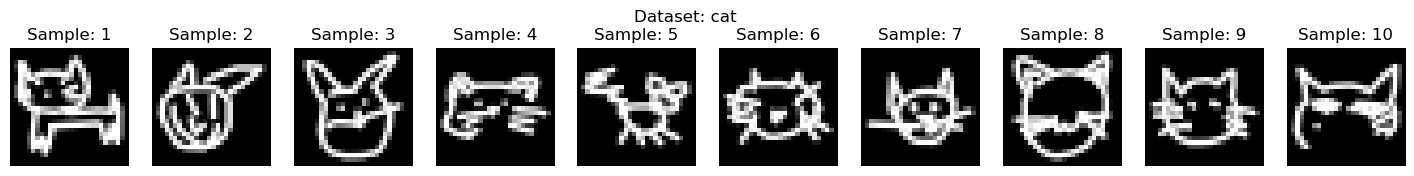

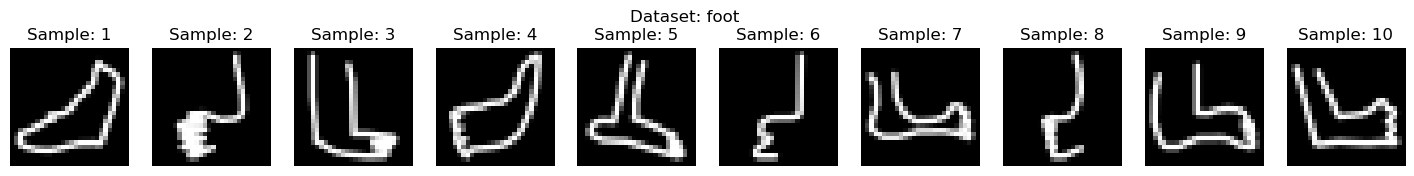

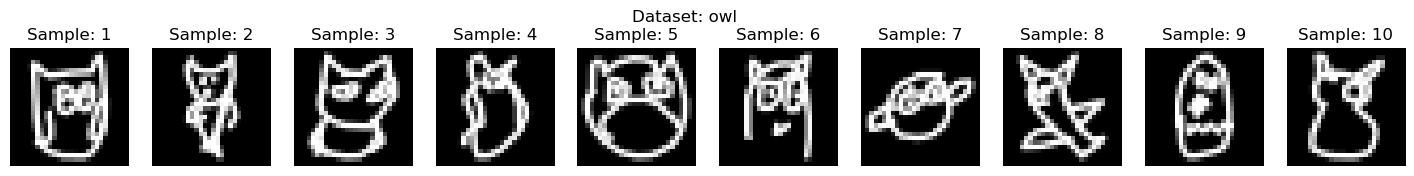

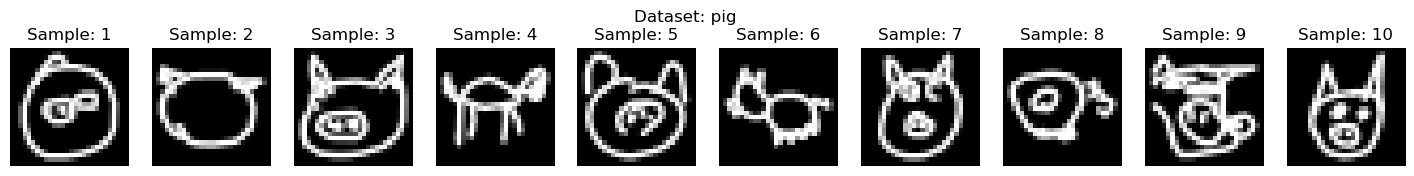

In [33]:
import numpy as np
import matplotlib.pyplot as plt


def read_and_show_data(path, dataset_name, show_num):
    file = np.load(path + '/' + dataset_name + '/' + dataset_name + '.npy')

    # 从数组中随机抽取元素的索引
    random_indices = np.random.choice(len(file), show_num, replace=False)
    # 根据索引获取相应的元素
    random_samples = file[random_indices]  

    # 绘图
    plt.figure(figsize=(18, 2))
    for i in range(show_num):
        plt.subplot(1, 10, i + 1) 

        image = random_samples[i].reshape(28, 28)

        plt.imshow(image, cmap='gray')
        plt.title(f"Sample: {i+1}")
        plt.axis('off')

    plt.suptitle(f"Dataset: {dataset_name}")
    plt.show()

    # 每张图片数据reshape
    data = []
    for pic in file:
        data.append(pic.reshape(1,28,28)) # channel，height，width
    

    return np.array(data) # 使用np数组

# 标签定义
# ‘ambulance’,‘apple’,‘bear’,‘bicycle’,‘bird’,‘bus’,‘cat’,‘foot’,‘owl’,‘pig‘
label = {0:'ambulance', 1:'apple', 2:'bear', 3:'bicycle', 4:'bird', 5:'bus', 6:'cat', 7:'foot', 8:'owl', 9:'pig'}

all_data = []

all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'ambulance', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'apple', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'bear', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'bicycle', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'bird', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'bus', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'cat', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'foot', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'owl', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'pig', 10))

# numsample，channel，height，width
all_data = np.array(all_data) # 转为np数组


为了使用torch提供的dataloader，需要自定义一个dataset类。

In [34]:
# 生成可用的数据集
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        label = self.labels[index]

        return data, label


train_x = []
train_y = []
val_x = []
val_y = []
test_x_in = []
test_y_in = []
test_x_out = []
test_y_out = []

# 在原数据集中进行分割，输出list
for i in range(all_data.shape[0]):
    total_length = all_data[i].shape[0]

    # 分布外数据集
    if i >= 7:
        random_indices = np.random.choice(all_data[i].shape[0], 100, replace=False) # 每类抽取100张图像构成分布外测试数据集
        random_samples = all_data[i][random_indices] 

        test_x_out.extend(random_samples)
        test_y_out.extend([i]*100)

    # 分布内数据集
    else:
        split1 = int(total_length * 0.7)
        split2 = int(total_length * 0.9)

        train_x.extend(all_data[i][:split1])
        train_y.extend([i]*split1)
        val_x.extend(all_data[i][split1:split2])
        val_y.extend([i]*(split2-split1))
        test_x_in.extend(all_data[i][split2:])
        test_y_in.extend([i]*(total_length - split2))


train_data = MyDataset(train_x,train_y)
val_data = MyDataset(val_x,val_y)
test_data_in = MyDataset(test_x_in,test_y_in)
test_data_out = MyDataset(test_x_out,test_y_out)

## 1.2 使用pytorch搭建网络

In [35]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


# 构建LeNet模型
class LeNet(nn.Module):
    def __init__(self):
        # 一个通道，10个分类
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2) # 1*28*28 -> 6*28*28
        self.pool = nn.AvgPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.sigmoid(self.conv1(x)))
        x = self.pool(torch.sigmoid(self.conv2(x)))
        x = x.flatten(1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

# 构建GoogleLeNet

## 1.3模型训练与验证

In [36]:
import time

# 打印与轮次有关的信息（acc、loss）
def show_info(epochs, acc_list, loss_list, val_acc_list, val_loss_list):
    plt.figure(figsize=(16, 4))
    
    plt.suptitle("Acc and Loss in each epoch")
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, epochs + 1, dtype=int), acc_list, label='acc')
    plt.plot(np.arange(1, epochs + 1, dtype=int), val_acc_list, label='val_acc')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, epochs + 1, dtype=int), loss_list, label='loss')
    plt.plot(np.arange(1, epochs+1, dtype=int), val_loss_list, label='val_loss')
    plt.legend()


    plt.show()

# 绘图展示结果概率分布
def show_result(path, dataset_name, show_num = 10, y_hat = None):
    file = np.load(path + '/' + dataset_name + '/' + dataset_name + '.npy')

    # 从数组中随机抽取元素的索引
    random_indices = np.random.choice(len(file), show_num, replace=False)
    # 根据索引获取相应的元素
    random_samples = file[random_indices]  

    # 绘图
    plt.figure(figsize=(18, 6))
    for i in range(show_num):
        plt.subplot(2, 10, i + 1) 

        image = random_samples[i].reshape(28, 28)

        plt.imshow(image, cmap='gray')
        plt.title(f"Sample: {i+1}")
        plt.axis('off')

        # 创建一个条形图
        plt.bar(class_labels, prediction)

    plt.suptitle(f"Dataset: {dataset_name}")
    plt.show()

    # 每张图片数据reshape
    data = []
    for pic in file:
        data.append(pic.reshape(1,28,28)) # channel，height，width



In [37]:
# 使用倒入的数据进行训练，最终将模型保存为文件
def train(model, device, learning_rate, num_epochs, batch_size, train_data, val_data):
    # 定义损失函数和优化器
    CE = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 训练模型
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) # 尝试多个batch_size训练

    # 模型选择
    val_loader = DataLoader(val_data, batch_size=100, shuffle=True)
    best_val_loss = float('inf')
    best_model = model
    best_epoch = 0
    best_val_loss = 99999999


    running_loss = [] #记录loss变化
    valling_loss = [] #记录val_loss变化
    start_time = time.time() # 记时
    train_acc_list = [] # 记录训练acc变化
    val_acc_list = []
    for epoch in range(num_epochs):
        running_loss.append(0.0)
        acc = 0

        model.to(device)

        # 训练
        model.train()
        for x, y in train_loader:
            x = x.float().to(device)
            y = y.long().to(device)

            optimizer.zero_grad()
            y_hat = model(x)
            
            loss = CE(y_hat, y)
            loss.backward()
            optimizer.step()

            running_loss[epoch] += loss.item()

            # acc记录
            acc += torch.sum(torch.max(y_hat, 1)[1] == y).item()

        # 验证与选优（记录acc）
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_acc = 0
            for x_val, y_val in val_loader:
                x_val = x_val.float().to(device)
                y_val = y_val.long().to(device)

                y_val_hat = model(x_val)
                val_loss += CE(y_val_hat, y_val).item()

                val_acc += torch.sum(torch.max(y_val_hat, 1)[1] == y_val).item()

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                best_epoch = epoch
            
            valling_loss.append(val_loss)
                
        
        train_acc_list.append(acc/len(train_data))
        val_acc_list.append(val_acc/len(val_data))
        

        # 早停
        if epoch > num_epochs/3 or epoch > 10:
            # 观察cost记录中最后10个数据，如果变化幅度不超过1%，就停止
            stop_flag = False
            if len(running_loss) > 10:
                last_10_costs = np.array(running_loss)[-10:]
                max_cost = max(last_10_costs)
                min_cost = min(last_10_costs)
                if (max_cost - min_cost) / max_cost < 0.01:
                    stop_flag = True
            if stop_flag:
                print(f"Training stopped due to small loss change in epoch {epoch}.")
                break    


        # 过程信息打印
        if epoch % 10 == 0:
            epoch_end_time = time.time()
            print(f"epoch: {epoch+1 :3} cost {(epoch_end_time - start_time):.2f}s after last print, sum loss: {running_loss[epoch]:.3f}")
            start_time = epoch_end_time

            
    print(f"Finished Training, best model saved in epoch {best_epoch+1} with val loss: {best_val_loss:.3f}")

    show_info(num_epochs, acc_list=train_acc_list, loss_list=running_loss, val_acc_list=val_acc_list, val_loss_list=valling_loss)

    # 保存模型
    torch.save(best_model.state_dict(), f"trained_{model._get_name()}_model_{num_epochs}epochs.pth")

# 模型测试并输出图像结果示例
def model_test(model, device, test_data_set, test_data_set_class):
    test_loader = DataLoader(test_data_set, batch_size=len(test_data_set), shuffle=False)

    acc = 0.0

    model.to(device)
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.float().to(device)
            y = y.long().to(device)

            y_hat = model(x)
            acc += torch.sum(torch.max(y_hat, 1)[1] == y).item()

        acc = acc/len(test_data_in)

    print(f"{test_data_set_class} data acc:{acc:.3f}")
    
    

### 1.3.1 LeNet模型训练

In [38]:
model_l = LeNet()
device = torch.device("mps")
epochs = 100

# 模型训练
# train(model_l, device, learning_rate=0.001, num_epochs=epochs, batch_size=1000, train_data=train_data, val_data=val_data)

# 加载模型
trained_model =LeNet()
trained_model.load_state_dict(torch.load(f'./trained_LeNet_model_{epochs}epochs.pth'))

# 模型测试
model_test(trained_model, device, test_data_in, 'in')
model_test(trained_model, device, test_data_out, 'out')



in data acc:0.895
out data acc:0.000


### 1.3.2 GoogleLeNet训练